# Parameter Estimation
First get handle to example model file:

In [1]:
%matplotlib inline
import os,glob

for i in glob.glob('*kholodenko.cps'):
    kholodenko_model= os.path.abspath(i)
    
print kholodenko_model
print os.path.isfile(kholodenko_model)

C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
True


Now simulate some synthetic data for sake of running an example. See the TimeCourse tutorial for details. 

In [2]:
import site
site.addsitedir(r'C:\Users\Ciaran\Documents\PyCoTools')
import PyCoTools,pandas
report= 'parameter_estimation_synthetic_data.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,start=0,end=1000,intervals=1000,step_size=1,
                            report_name = report)

## validate that its worked
print pandas.read_csv(TC.kwargs['report_name'],sep='\t').head()

## Give fake data a meaningful name
data1 = TC.kwargs['report_name']

INFO:root:__init__:26:Initializing PyCoTools
INFO:root:__init__:27:Initializing logging System
INFO:root:__init__:28:logging config file at: C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\logging_config.conf
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:1135:CopasiML: <Element {http://www.copasi.org/static/schema}COPASI at 0x45cfb88>
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:946:created a 'time_course' type report
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko

Note that it is completely necessary to have column headings in a data file that exactly match a model variable. Independant variables can be mapped easily by appending the suffic `'_indep'` to the variable. If you had two data sets that stimulated cell cultures at different concentrations for example, you could have `stimulation_indep` as a column heading in both with each containing the amount of stimulant that was used in the experiment. 

# Setup and run single parameter estimation 
Now we're ready to setup and run a parameter estimation

In [3]:
import PyCoTools, os
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1)

DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python


The behaviour of the parameter estimation can be using keyword arguments. For example, to change the optimization algorithm, add the `method` argument:

In [ ]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='HookeJeeves')

All algorithm specific parameters should be defined here here as well. Take a look at the GUI to see which parameters exist (i.e. swarm size in particle swarm). 

In [4]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='HookeJeeves',
                                        iteration_limit = 100,
                                        tolerance = 1e-10)

## sanity check
print 'tolerance = ',PE.kwargs['tolerance']
print 'iteration_limit =', PE.kwargs['iteration_limit']

DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
tolerance =  1e-10
iteration_limit = 100


Now use the `write_config_template` method to create a parameter estimation configuration file specific for your model:

In [5]:
PE.write_config_template()

The filename can user specified by passing an argument to the `ConfigFilename` kwarg on instantiation. Here we use the default:

In [ ]:
## check that the config filename exists
print os.path.isfile(PE.kwargs['config_filename'])
print 'Your config file is here: {}'.format(PE.kwargs['config_filename'])

A parameter estimation configuration file has 7 columns but the last three are not meant to be modified in any way. Each row corresponds to a parameter in your model and by default all kinetic parameters (local and global) and initial concentration parameters are included in the configuration. To exclude a parameter from the estimation simply delete the row corresponding to the parameter you wish to remove. Also, specify the estimation boundaries for each parameter and optionally the starting value. It is common to randomize the start values which by default is True (i.e. `randomize_start_vales = True`) . If you would like to use the configuration file as to specify start values then you must set the `use_template_start_values` option to `True`. 

After modification, save and close the file. In the example, no modifications we're made and so all kinetic and initial concentration parameters are estimated. 

Now use the `setup()` and `run()` methods. 

In [5]:
PE.setup()

DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:1964:Removing all pre-existing experiments from copasi mapping interface
DEBUG:PyCoTools.pycopi:pycopi:1967:Mapping experiment parameter_estimation_synthetic_data.txt
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:939:created a 'parameter_estimation' report
INFO:PyCoTools.pycopi:pycopi:924:footer is: <Element Footer at 0xa9a6d88>
DEBUG:PyCoTools.pycopi:pycopi:929:Repor

Open the model and check the parameter estimation task (optionally run the next cell). The ParameterEstimation class has performed the configuration. 

In [ ]:
import os
os.system('CopasiUI {}'.format(kholodenko_model))
##  remember to close the model before continuing

The `run()` method will run the copasi file using `CopasiSE` behind the scenes. 

In [6]:
PE.run() # will take some time

DEBUG:PyCoTools.pycopi:pycopi:2608:running ParameterEstimation. Data reported to file: C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko_PE_results.txt
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:2629:Shape of estimated parameters: (1, 31)
DEBUG:PyCoTools.pycopi:pycopi:2638:These are your estimated parameters:                                                 0
(phosphorylation of MAPKK).KK3              1e-06
(MAPKKK activation).K1                  0.0618007
(dephosphorylation of MAPK-PP).V9        0.926361
(phosphorylation of MAPK).k7          2.31391e-05
(phosphorylation of MAPK-P).k8          0.0187084
(MAPKKK inactivation).KK2             3.35634e-05
(MAPKKK inactivatio

<PyCoTools.pycopi.Run instance at 0x000000000B0EA888>

The `run()` method should take a bit of time and the output will be the parameter parmeters.

In [4]:
import pandas
import matplotlib.pyplot as plt
import numpy
## lets take a look at the parameter estimation results
pe_data= pandas.read_csv(PE.kwargs['report_name'],sep='\t') 

print 'These are your estimated parameters:\n\n{}'.format(pe_data.transpose())

These are your estimated parameters:

                                                 0
(phosphorylation of MAPKK).KK3          812.374000
(MAPKKK activation).K1                   99.888800
(dephosphorylation of MAPK-PP).V9         0.000001
(phosphorylation of MAPK).k7              0.000001
(phosphorylation of MAPK-P).k8          376.977000
(MAPKKK inactivation).KK2                 0.000002
(MAPKKK inactivation).V2              23224.300000
(phosphorylation of MAPKK).k3          8130.140000
(phosphorylation of MAPKK-P).k4           0.000001
(dephosphorylation of MAPKK-PP).KK5  156647.000000
(dephosphorylation of MAPK-PP).KK9       26.525300
(dephosphorylation of MAPKK-P).KK6        5.013020
(phosphorylation of MAPKK-P).KK4          0.000102
(MAPKKK activation).V1                    0.000001
(MAPKKK activation).Ki                    0.000001
(phosphorylation of MAPK).KK7             0.000001
(dephosphorylation of MAPK-P).KK10      238.210000
(phosphorylation of MAPK-P).KK8        3077.

## Multiple Data Files
PyCoTools can easily handle multiple data files by giving `ParameterEsimation` a list of data file paths. Lets simulate some more data.

Lets first change a model parameter so both sets of simulated data are not identical:

In [4]:
import PyCoTools,os
## Original value of Mek1-PP at time 0 is 10 (though your previous estimations may have changed it)
GMQ=PyCoTools.pycopi.GetModelQuantities(kholodenko_model)
print 'Old parameter value: {}'.format(GMQ.get_IC_cns()['Mek1-PP']['concentration'])

#Use InsertParameters to change it to 20
I=PyCoTools.pycopi.InsertParameters(kholodenko_model,parameter_dict={'Mek1-PP':20})
GMQ=PyCoTools.pycopi.GetModelQuantities(kholodenko_model)
print 'New Parameter Value: {}'.format(GMQ.get_IC_cns()['Mek1-PP']['concentration'])



DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
Old parameter value: 0.00417677999999
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:4769:Local parameters being inserted into mode: []
DEBUG:PyCoTools.pycopi:pycopi:4800:States:	 ['Model_3', 'Metabolite_7', 'Metabolite_13', 'Metabolite_1', 'Metabolite_5', 'Metabolite_11', 'Metabolite_9', 'Metabolite_3', 'Metabolite_15', 'Compartment_1']
DEBUG:PyCoTools.pycopi:pycopi:4815:Added 0 for first parameter in sequence
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
New Parameter Value: 20.0


And Simulate some data:

DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:1135:CopasiML: <Element {http://www.copasi.org/static/schema}COPASI at 0xabdb888>
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:946:created a 'time_course' type report
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:1410:getting report key
DEBUG:PyCoTools.pycopi:pycopi:1452:setting up deterministic time course
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents

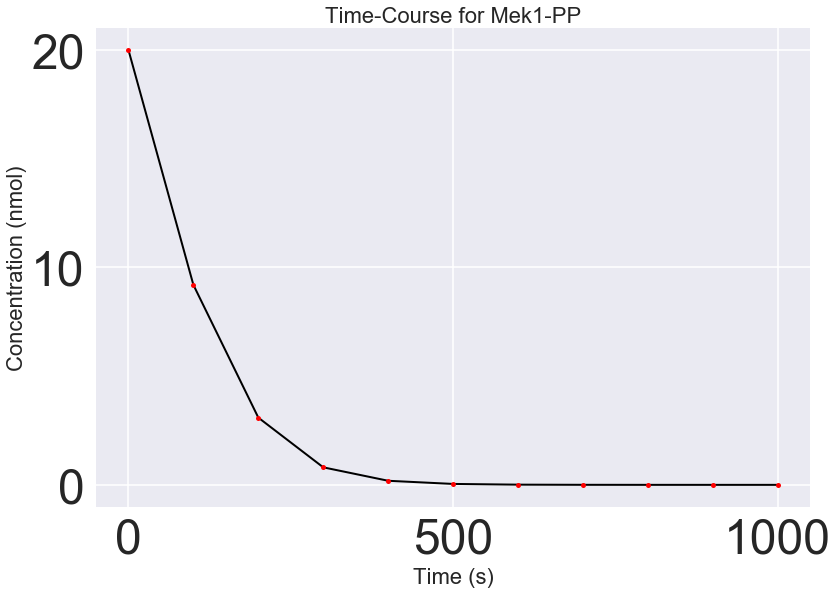

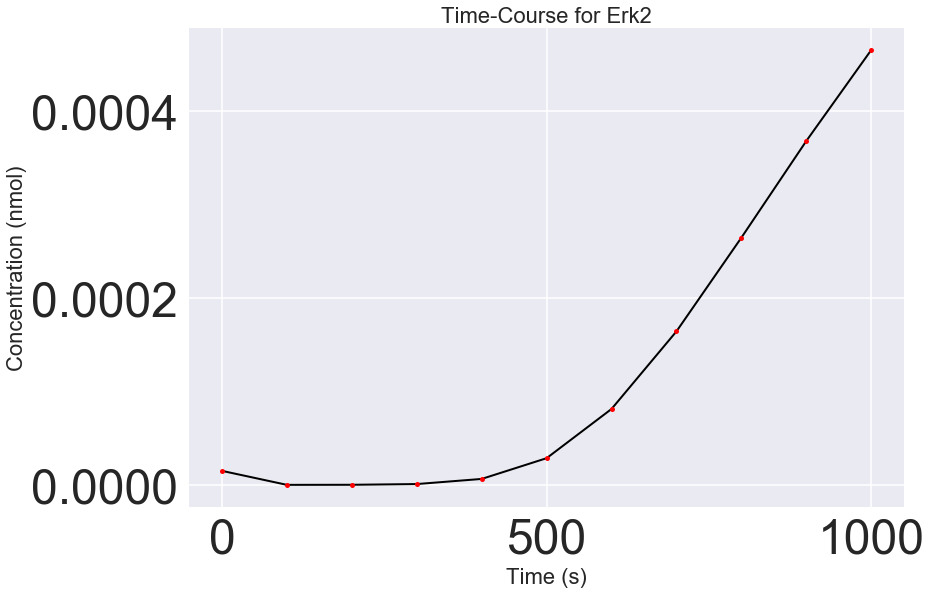

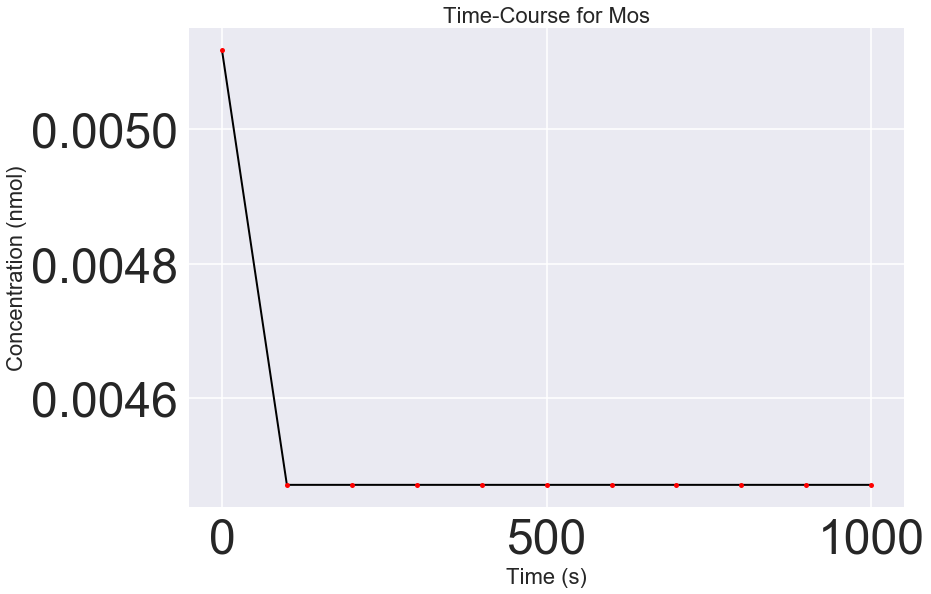

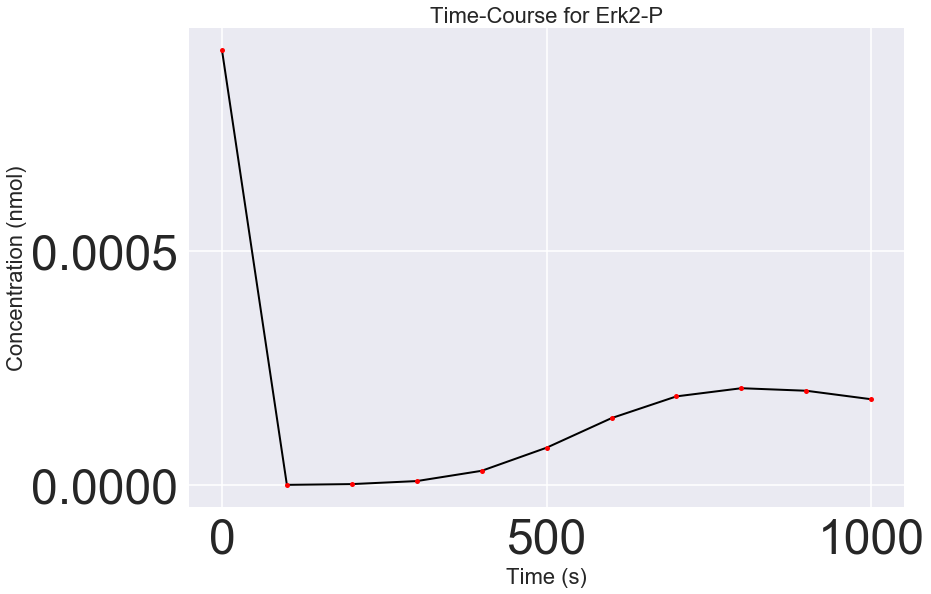

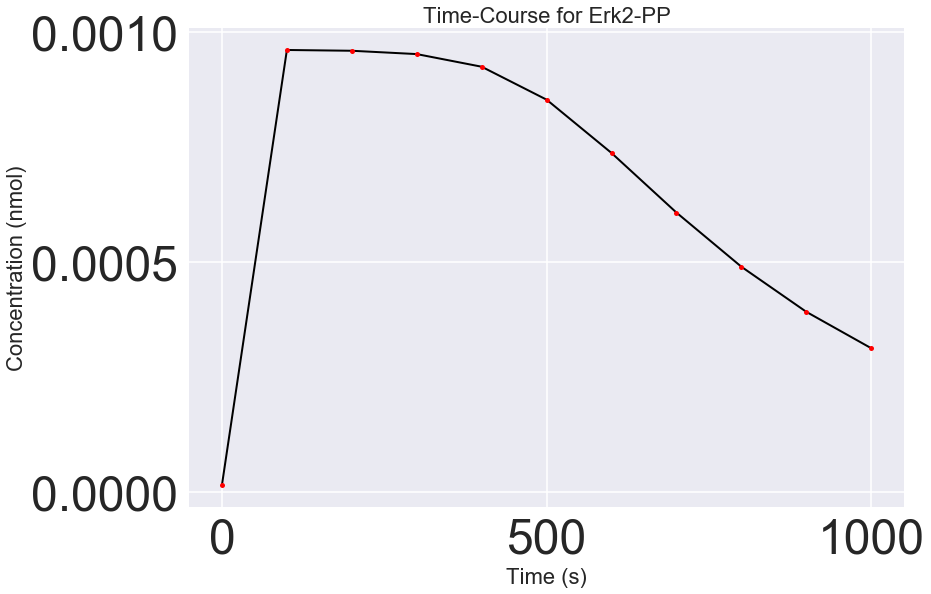

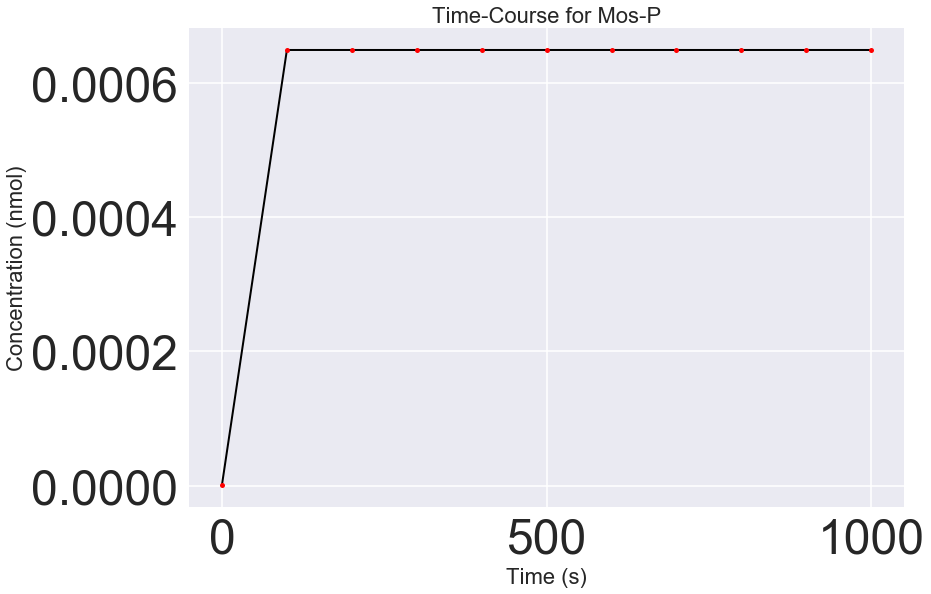

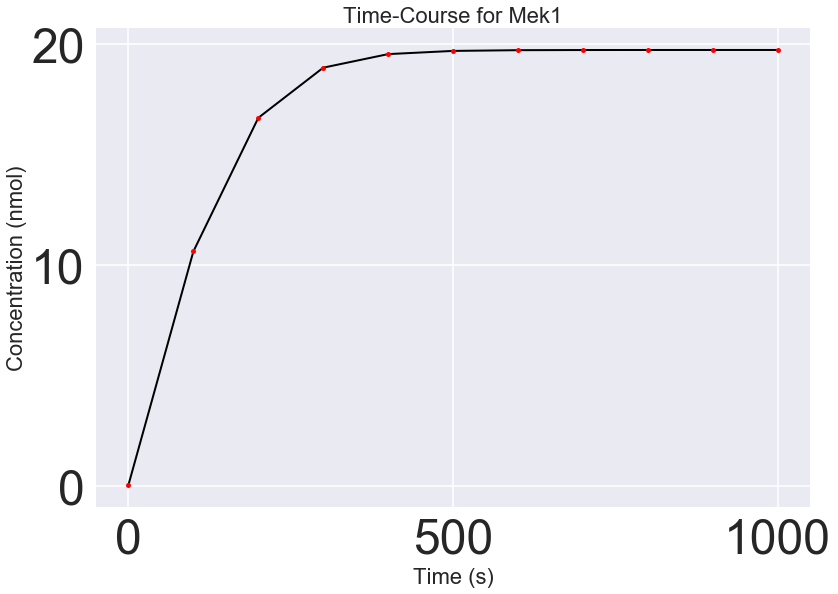

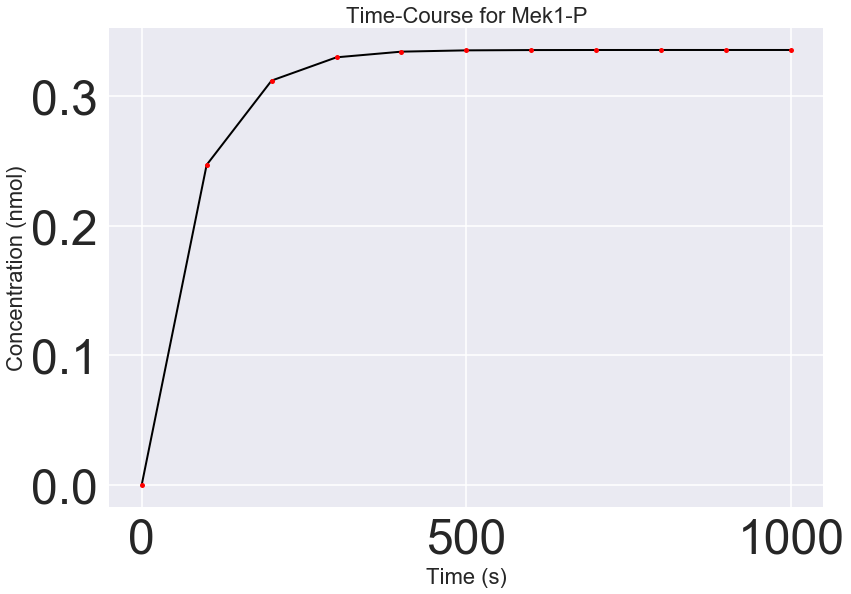

In [5]:
import PyCoTools,pandas
report= 'parameter_estimation_synthetic_data2.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,
                               end=1000,
                               intervals=10,
                               step_size=100,
                               report_name = report,
                               plot=True)


## Give fake data a meaningful name
data2 = TC.kwargs['report_name']

Now setup a parameter estimation like before and run. Note that we already have a configuration file with the default filename and therefore do not need to rewrite one. 

In this parameter estimation we know that the difference between the two data sets is the initial concentration of 'Mek1-PP'. Usually in a parameter estimation this would be mapped to a COPASI independent variable by adding another column in any data files. See the [doc](http://copasi.org/Support/User_Manual/Tasks/Parameter_Estimation/Experimental_Data/) for more on independent valiables. To implement independ variables with PyCoTools, append the suffix '_indep' onto the back of the variable name (i.e. here 'Mek1-PP_indep') and the mapping will automatically be to the independent variable. This is not done here for brevity. 

In [21]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,[data1,data2],
                      method='GeneticAlgorithm',
                      population_size = 50, 
                      number_of_generations= 50,
                      report_name = report)
PE.setup()
PE.run()

os.system('CopasiUI {}'.format(kholodenko_model))

DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:1964:Removing all pre-existing experiments from copasi mapping interface
DEBUG:PyCoTools.pycopi:pycopi:1967:Mapping experiment parameter_estimation_synthetic_data.txt
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:1967:Mapping experiment parameter_estimation_synthetic_data2.txt
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoT

0

Lets check the parameter estimation data:

In [25]:
import pandas
print pandas.read_csv(PE.kwargs['report_name'],sep='\t').transpose()

                                                  0
(phosphorylation of MAPKK).KK3             0.924031
(MAPKKK activation).K1                    23.560100
(dephosphorylation of MAPK-PP).V9          0.006879
(phosphorylation of MAPK).k7               0.000366
(phosphorylation of MAPK-P).k8          7147.490000
(MAPKKK inactivation).KK2                  0.272381
(MAPKKK inactivation).V2                   0.327156
(phosphorylation of MAPKK).k3              2.262580
(phosphorylation of MAPKK-P).k4            0.000398
(dephosphorylation of MAPKK-PP).KK5   277100.000000
(dephosphorylation of MAPK-PP).KK9         0.081688
(dephosphorylation of MAPKK-P).KK6         0.001259
(phosphorylation of MAPKK-P).KK4       14214.800000
(MAPKKK activation).V1                     0.636790
(MAPKKK activation).Ki                     0.000083
(phosphorylation of MAPK).KK7              0.000161
(dephosphorylation of MAPK-P).KK10         4.491000
(phosphorylation of MAPK-P).KK8            0.004286
(dephosphory

# Visualization 
Use the `Plot` keyword to visualize the data

In [6]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,[data1,data2],
                      method='GeneticAlgorithm',
                      population_size = 20,
                      number_of_generations = 20,
                      report_name = report,
                      plot=True)
PE.setup()
PE.run()


DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file Kholodenko.cps has been parsed into Python
DEBUG:PyCoTools.pycopi:pycopi:1968:Removing all pre-existing experiments from copasi mapping interface
DEBUG:PyCoTools.pycopi:pycopi:1971:Mapping experiment parameter_estimation_synthetic_data.txt
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:1971:Mapping experiment parameter_estimation_synthetic_data2.txt
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoTools\PyCoToolsTutorial\Kholodenko.cps
DEBUG:PyCoTools.pycopi:pycopi:119:model written to C:\Users\Ciaran\Documents\PyCoTools\PyCoT

<PyCoTools.pycopi.Run instance at 0x000000000AA09F48>

An alternative is to simply insert the parameters and the open the model using the UI and simulate manually using current solution statistics.

In [9]:
import PyCoTools
import os
import pandas

pe_data = pandas.read_csv(report,sep='\t')

print pe_data

PyCoTools.pycopi.InsertParameters(kholodenko_model,parameter_path = report, index = 0)

os.system('CopasiUI {}'.format(kholodenko_model))



   (phosphorylation of MAPKK).KK3  (MAPKKK activation).K1  \
0                        0.041899                  27.712   

   (dephosphorylation of MAPK-PP).V9  (phosphorylation of MAPK).k7  \
0                           0.000092                      0.000012   

   (phosphorylation of MAPK-P).k8  (MAPKKK inactivation).KK2  \
0                           59571                   0.000012   

   (MAPKKK inactivation).V2  (phosphorylation of MAPKK).k3  \
0                  0.001084                       0.000018   

   (phosphorylation of MAPKK-P).k4  (dephosphorylation of MAPKK-PP).KK5  \
0                         0.000002                             0.000001   

    ...     (MAPKKK activation).n   Mek1-PP      Erk2       Mos    Erk2-P  \
0   ...                  0.000001  0.000001  0.000001  0.000001  0.000001   

    Erk2-PP     Mos-P      Mek1    Mek1-P      RSS  
0  0.000001  0.000133  0.000002  0.000002  0.10066  

[1 rows x 31 columns]
DEBUG:PyCoTools.pycopi:pycopi:108:copasi file K

0